# APTOS 2019 Diabetic Retinopathy - MobileNetV3-Small

## Standalone Training (No Knowledge Distillation)

**Setup:** Make sure the APTOS 2019 dataset is attached via '+ Add data'

In [1]:
import os, time, copy, math
import random
import numpy as np
from pathlib import Path
from collections import defaultdict
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print('Torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Torch version: 2.8.0+cu126
Device: cuda


## Dataset Configuration

In [2]:
# Dataset paths - Update this to point to your Kaggle dataset
DATASET_ROOT = '/kaggle/input/datasets/almiraraisa/aptos-2019'  # Your dataset name here
IMAGE_DIR = f'{DATASET_ROOT}/train_images'
LABEL_CSV = f'{DATASET_ROOT}/train.csv'

print("Dataset Configuration")
print("="*70)

# Verify dataset is attached
if not os.path.exists(DATASET_ROOT):
    print("\n⚠️ ERROR: Dataset not found!")
    print(f"Expected path: {DATASET_ROOT}")
    print("\nPlease attach your APTOS 2019 dataset:")
    print("1. Click '+ Add data' in the right panel")
    print("2. Search for your 'APTOS 2019' dataset")
    print("3. Add it to this notebook")
    print("4. Update DATASET_ROOT in this cell if needed\n")
    raise FileNotFoundError(f"Dataset not found at {DATASET_ROOT}")

if not os.path.exists(IMAGE_DIR):
    raise FileNotFoundError(
        f"Image directory not found: {IMAGE_DIR}\n"
        "Expected structure: {DATASET_ROOT}/train_images/"
    )
if not os.path.exists(LABEL_CSV):
    raise FileNotFoundError(
        f"CSV file not found: {LABEL_CSV}\n"
        "Expected: {DATASET_ROOT}/train.csv"
    )

print(f"✓ Dataset root: {DATASET_ROOT}")
print(f"✓ Image directory: {IMAGE_DIR}")
print(f"✓ Label CSV: {LABEL_CSV}")

# Count images
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.png')]
print(f"\nFound {len(image_files)} images")

# Load CSV
df = pd.read_csv(LABEL_CSV)
print(f"\nCSV shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Auto-detect image filename column
_KNOWN_ID_COLS = ['id_code', 'id_name', 'image_id', 'filename', 'image', 'file']
IMG_COL = None
for candidate in _KNOWN_ID_COLS:
    if candidate in df.columns:
        IMG_COL = candidate
        break

if IMG_COL is None:
    IMG_COL = [c for c in df.columns if c != 'diagnosis'][0]

print(f"\nImage filename column: '{IMG_COL}'")

# Ensure filenames have .png extension
df[IMG_COL] = df[IMG_COL].astype(str).apply(
    lambda x: x if x.endswith('.png') else x + '.png'
)

# Verify first image
_sample_path = Path(IMAGE_DIR) / df[IMG_COL].iloc[0]
if not _sample_path.exists():
    raise FileNotFoundError(
        f"First image not found: {_sample_path}\n"
        f"Check that IMAGE_DIR is correct and contains the images."
    )
print(f"✓ Sample image verified: {_sample_path.name}")

# Class distribution
print("\n" + "="*70)
print("Class Distribution")
print("="*70)
print(df['diagnosis'].value_counts().sort_index())

CLASS_NAMES = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")
print("\n" + "="*70)
print("✓ DATASET READY")
print("="*70)

Dataset Configuration
✓ Dataset root: /kaggle/input/datasets/almiraraisa/aptos-2019
✓ Image directory: /kaggle/input/datasets/almiraraisa/aptos-2019/train_images
✓ Label CSV: /kaggle/input/datasets/almiraraisa/aptos-2019/train.csv

Found 3662 images

CSV shape: (3662, 2)
Columns: ['id_code', 'diagnosis']

First 5 rows:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Image filename column: 'id_code'
✓ Sample image verified: 000c1434d8d7.png

Class Distribution
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Number of classes: 5
Class names: ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

✓ DATASET READY


In [3]:
from sklearn.model_selection import train_test_split

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Reproducible stratified 70/15/15 split
set_seed(42)
train_df, tmp_df = train_test_split(df, test_size=0.30, stratify=df['diagnosis'], random_state=42)
val_df, test_df  = train_test_split(tmp_df, test_size=0.50, stratify=tmp_df['diagnosis'], random_state=42)

print(f"Train : {len(train_df):>5}  |  Val : {len(val_df):>5}  |  Test : {len(test_df):>5}")
print("\nTrain class dist:\n", train_df['diagnosis'].value_counts().sort_index())
print("\nVal   class dist:\n", val_df['diagnosis'].value_counts().sort_index())
print("\nTest  class dist:\n", test_df['diagnosis'].value_counts().sort_index())

Train :  2563  |  Val :   549  |  Test :   550

Train class dist:
 diagnosis
0    1263
1     259
2     699
3     135
4     207
Name: count, dtype: int64

Val   class dist:
 diagnosis
0    271
1     55
2    150
3     29
4     44
Name: count, dtype: int64

Test  class dist:
 diagnosis
0    271
1     56
2    150
3     29
4     44
Name: count, dtype: int64


In [4]:
class AptosDataset(Dataset):
    """
    Dataset for Aptos 2019 Blindness Detection.
    Uses the globally detected IMG_COL for the filename column.
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.df        = dataframe.reset_index(drop=True)
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.classes      = CLASS_NAMES
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        path  = self.image_dir / row[IMG_COL]
        img   = Image.open(path).convert('RGB')
        label = int(row['diagnosis'])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [5]:
# Augmentation for fundus/retinal images
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.70, 1.0), ratio=(0.85, 1.15)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

In [6]:
BATCH_SIZE = 18

train_ds   = AptosDataset(train_df, IMAGE_DIR, transform=train_transforms)
val_ds     = AptosDataset(val_df,   IMAGE_DIR, transform=val_transforms)
test_ds    = AptosDataset(test_df,  IMAGE_DIR, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 143 | Val batches: 31 | Test batches: 31


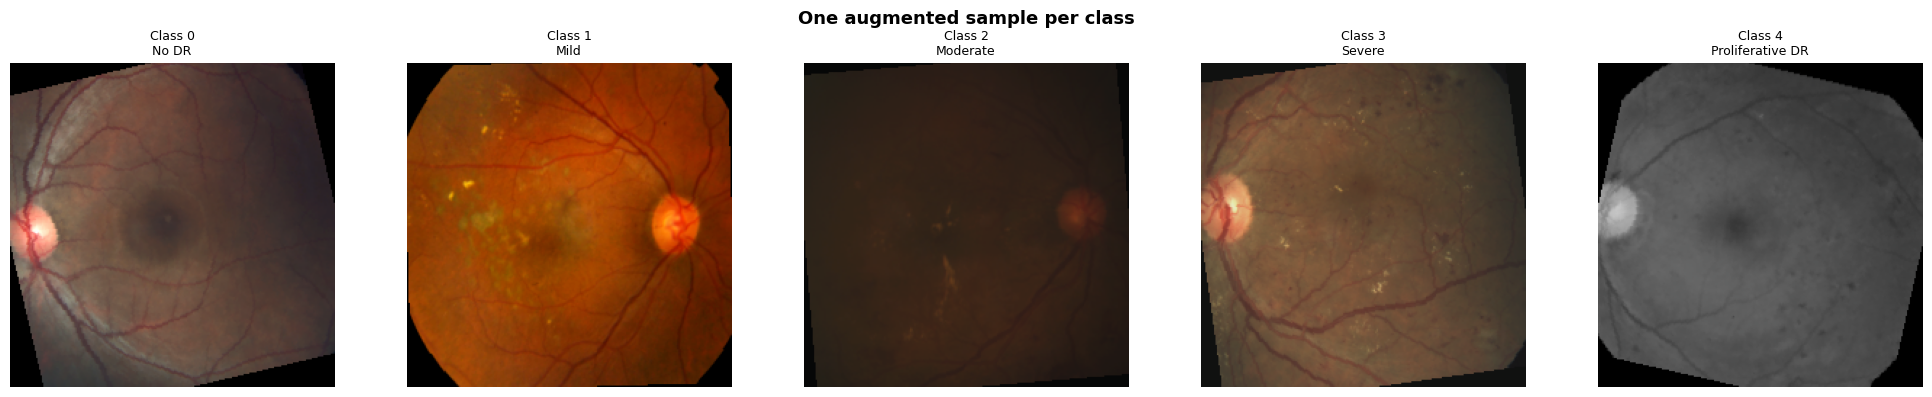

In [7]:
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Show one augmented sample per class
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(4 * NUM_CLASSES, 4))
for cls_idx in range(NUM_CLASSES):
    subset    = train_df[train_df['diagnosis'] == cls_idx]
    first_row = subset.iloc[0]
    path      = Path(IMAGE_DIR) / first_row[IMG_COL]

    img_pil = Image.open(path).convert('RGB')
    img_t   = train_transforms(img_pil)

    ax = axes[cls_idx]
    plt.sca(ax)
    imshow(img_t)
    ax.set_title(f"Class {cls_idx}\n{CLASS_NAMES[cls_idx]}", fontsize=9)

plt.suptitle("One augmented sample per class", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
def print_model_parameters(model, model_name="Model"):
    total_params     = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n--- {model_name} Parameters ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print("---------------------------------")

In [9]:
def get_model(num_classes=5, pretrained=True):
    """
    MobileNetV3-Small with replaced classification head.
    """
    try:
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None
        model   = models.mobilenet_v3_small(weights=weights)
    except Exception as e:
        print('Warning: could not load MobileNetV3-Small pretrained weights:', e)
        model = models.mobilenet_v3_small(weights=None)

    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

In [10]:
def train_model(model, train_loader, val_loader, device,
                epochs=50, lr=1e-3, save_path='./best_model.pth'):
    """
    Standard supervised training with:
      • CrossEntropyLoss (with class weights)
      • AdamW optimizer
      • CosineAnnealingLR scheduler
      • Mixed-precision (AMP)
    """
    model = model.to(device)

    # Class weights (inverse-frequency)
    labels_all = train_loader.dataset.df['diagnosis'].values
    counts     = np.bincount(labels_all, minlength=NUM_CLASSES).astype(np.float32)
    weights    = 1.0 / (counts + 1e-6)
    weights    = weights / weights.sum() * NUM_CLASSES
    weights    = torch.tensor(weights, dtype=torch.float32).to(device)
    print("Class weights:", weights.cpu().numpy())

    criterion  = nn.CrossEntropyLoss(weight=weights)
    optimizer  = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler     = GradScaler()

    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss':   [], 'val_acc':   []
    }

    for epoch in range(epochs):
        # TRAIN
        model.train()
        run_loss, total, correct = 0.0, 0, 0

        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast():
                outs = model(imgs)
                loss = criterion(outs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            run_loss += loss.item()
            _, preds = torch.max(outs, 1)
            total    += labels.size(0)
            correct  += preds.eq(labels).sum().item()

            if batch_idx % 20 == 0:
                del imgs, labels, outs
                cleanup_memory()

        scheduler.step()

        avg_train_loss = run_loss / max(1, len(train_loader))
        train_acc      = 100.0 * correct / total if total > 0 else 0.0

        # VALIDATION
        model.eval()
        val_loss, total, correct = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with autocast():
                    outs = model(imgs)
                    loss = criterion(outs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outs, 1)
                total    += labels.size(0)
                correct  += preds.eq(labels).sum().item()
                del imgs, labels, outs

        avg_val_loss = val_loss / max(1, len(val_loader))
        val_acc      = 100.0 * correct / total if total > 0 else 0.0

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:>3}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}  Acc: {train_acc:.2f}% | "
                  f"Val Loss: {avg_val_loss:.4f}  Acc: {val_acc:.2f}% | "
                  f"LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        cleanup_memory()

    # Reload best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()
    print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
    return model, best_val_acc, history

In [11]:
def run_experiment():
    seeds  = [3, 8, 5]
    EPOCHS = 50

    all_results = {
        'test_accs':             [],
        'val_accuracies':        [],
        'train_losses':          [],
        'train_accs':            [],
        'val_losses':            [],
        'classification_reports': [],
        'confusion_matrices':    [],
        'y_true_all':            [],
        'y_pred_all':            []
    }

    print("="*80)
    print("MobileNetV3-Small – Aptos 2019 Blindness Detection – 3-Run Experiment")
    print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Test: {len(test_ds)}")
    print(f"Classes: {CLASS_NAMES}")
    print(f"Batch size: {BATCH_SIZE}  |  Epochs per run: {EPOCHS}")
    print("="*80)

    for run_idx, seed in enumerate(seeds):
        print(f"\n{'='*60}")
        print(f"RUN {run_idx + 1}/3 – Seed: {seed}")
        print(f"{'='*60}")

        set_seed(seed)
        cleanup_memory()

        model = get_model(num_classes=NUM_CLASSES, pretrained=True).to(device)

        if run_idx == 0:
            print_model_parameters(model, "MobileNetV3-Small")

        # Train
        model, best_val_acc, history = train_model(
            model, train_loader, val_loader, device,
            epochs=EPOCHS, lr=1e-3,
            save_path=f'./best_model_seed{seed}.pth'
        )

        all_results['val_accuracies'].append(history['val_acc'])
        all_results['train_losses'].append(history['train_loss'])
        all_results['train_accs'].append(history['train_acc'])
        all_results['val_losses'].append(history['val_loss'])

        # Test
        print("Evaluating on test set…")
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs   = imgs.to(device)
                outs   = model(imgs)
                _, preds = torch.max(outs, 1)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.cpu().numpy())
                del imgs, outs

        test_acc = 100.0 * np.mean(np.array(y_true) == np.array(y_pred))
        print(f"Test accuracy (Run {run_idx + 1}): {test_acc:.2f}%")
        all_results['test_accs'].append(test_acc)
        all_results['y_true_all'].append(y_true)
        all_results['y_pred_all'].append(y_pred)

        report = classification_report(y_true, y_pred,
                                       target_names=CLASS_NAMES,
                                       output_dict=True, zero_division=0)
        all_results['classification_reports'].append(report)
        all_results['confusion_matrices'].append(confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES)))

        del model
        cleanup_memory()
        print(f"Run {run_idx + 1} completed. Memory cleaned.")

    # ─────────────────────── RESULTS ───────────────────────
    print(f"\n{'='*80}")
    print("FINAL RESULTS – AVERAGED ACROSS 3 RUNS")
    print(f"{'='*80}")

    test_accs = np.array(all_results['test_accs'])
    print(f"\nTEST ACCURACY:")
    print(f"  Individual : {test_accs}")
    print(f"  Mean       : {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    print(f"  Best       : {np.max(test_accs):.2f}%")
    print(f"  Worst      : {np.min(test_accs):.2f}%")

    # Averaged curves
    avg_val_acc    = np.mean(all_results['val_accuracies'], axis=0)
    std_val_acc    = np.std(all_results['val_accuracies'], axis=0)
    avg_train_loss = np.mean(all_results['train_losses'], axis=0)
    avg_val_loss   = np.mean(all_results['val_losses'], axis=0)
    avg_train_acc  = np.mean(all_results['train_accs'], axis=0)

    # Confusion matrix stats
    avg_cm      = np.mean(all_results['confusion_matrices'], axis=0)
    std_cm      = np.std(all_results['confusion_matrices'], axis=0)
    avg_cm_norm = avg_cm / avg_cm.sum(axis=1, keepdims=True)

    print("\nAVERAGE CONFUSION MATRIX (Normalized):")
    print(f"{'':>16}", end="")
    for cn in CLASS_NAMES:
        print(f"{cn:>16}", end="")
    print()
    for i, cn in enumerate(CLASS_NAMES):
        print(f"{cn:>16}", end="")
        for j in range(NUM_CLASSES):
            print(f"{avg_cm_norm[i,j]:>16.3f}", end="")
        print()

    class_accs = [avg_cm_norm[i, i] * 100 for i in range(NUM_CLASSES)]
    print("\nPER-CLASS ACCURACY:")
    for i, cn in enumerate(CLASS_NAMES):
        support = int(avg_cm[i].sum())
        print(f"  {cn:>20}: {class_accs[i]:>6.2f}%   (avg support {support})")

    best_cls  = int(np.argmax(class_accs))
    worst_cls = int(np.argmin(class_accs))
    print(f"\n  Best  : {CLASS_NAMES[best_cls]}  ({class_accs[best_cls]:.2f}%)")
    print(f"  Worst : {CLASS_NAMES[worst_cls]}  ({class_accs[worst_cls]:.2f}%)")

    # Top misclassifications
    print("\nTOP MISCLASSIFICATIONS:")
    miscs = []
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if i != j:
                miscs.append((avg_cm[i, j], i, j))
    miscs.sort(reverse=True)
    for k, (freq, ti, pi) in enumerate(miscs[:5]):
        pct = (freq / avg_cm[ti].sum()) * 100 if avg_cm[ti].sum() > 0 else 0
        print(f"  {k+1}. {CLASS_NAMES[ti]:>20} → {CLASS_NAMES[pi]:<20}: "
              f"{freq:>6.1f} cases  ({pct:.1f}% of {CLASS_NAMES[ti]})")

    # ─────────────────── VISUALIZATION ─────────────────────
    fig, axes = plt.subplots(3, 4, figsize=(22, 15))
    fig.suptitle("MobileNetV3-Small – Aptos 2019 Blindness Detection – 3-Run Summary",
                 fontsize=14, fontweight='bold')

    # 1 – Test accuracy box
    ax = axes[0, 0]
    ax.boxplot([test_accs], labels=['MobileNetV3-S'])
    ax.scatter([1]*len(test_accs), test_accs, color='red', s=50, zorder=5)
    ax.set_title('Test Accuracy Distribution')
    ax.set_ylabel('Accuracy (%)')
    ax.grid(True, alpha=0.3)

    # 2 – Train vs Val accuracy curves
    ax = axes[0, 1]
    epochs_range = range(len(avg_val_acc))
    ax.plot(epochs_range, avg_train_acc, 'b-', linewidth=2, label='Train')
    ax.plot(epochs_range, avg_val_acc,   'o-', color='orange', linewidth=2, markersize=0, label='Val (mean)')
    ax.fill_between(epochs_range,
                    avg_val_acc - std_val_acc,
                    avg_val_acc + std_val_acc,
                    alpha=0.25, color='orange', label='Val ± 1σ')
    ax.set_title('Accuracy Curves (averaged)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 3 – Train & Val loss curves
    ax = axes[0, 2]
    ax.plot(avg_train_loss, 'b-', linewidth=2, label='Train Loss')
    ax.plot(avg_val_loss,   'r-', linewidth=2, label='Val Loss')
    ax.set_title('Loss Curves (averaged)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 4 – Individual val-acc runs
    ax = axes[0, 3]
    colors_run = ['#e6194b', '#3cb44b', '#4363d8']
    for i, va in enumerate(all_results['val_accuracies']):
        ax.plot(va, color=colors_run[i], alpha=0.7, label=f'Run {i+1}')
    ax.plot(avg_val_acc, 'k-', linewidth=2.5, label='Mean')
    ax.set_title('Individual Val-Acc Runs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Val Accuracy (%)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 5 – Average CM (raw)
    ax = axes[1, 0]
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm.astype(int),
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title('Avg CM (Raw Counts)')
    ax.tick_params(axis='x', rotation=30)

    # 6 – Average CM (normalised)
    ax = axes[1, 1]
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm_norm,
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Blues', values_format='.2f')
    ax.set_title('Avg CM (Normalised)')
    ax.tick_params(axis='x', rotation=30)

    # 7 – CM std-dev
    ax = axes[1, 2]
    disp = ConfusionMatrixDisplay(confusion_matrix=std_cm,
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Reds', values_format='.1f')
    ax.set_title('CM Std Dev across runs')
    ax.tick_params(axis='x', rotation=30)

    # 8 – Best-run CM
    best_run = int(np.argmax(test_accs))
    ax = axes[1, 3]
    disp = ConfusionMatrixDisplay(confusion_matrix=all_results['confusion_matrices'][best_run],
                                  display_labels=CLASS_NAMES)
    disp.plot(ax=ax, cmap='Greens', values_format='d')
    ax.set_title(f'Best Run CM (Run {best_run+1}: {test_accs[best_run]:.1f}%)')
    ax.tick_params(axis='x', rotation=30)

    # 9 – Per-class accuracy bar
    ax = axes[2, 0]
    bar_colors = ['green' if i == best_cls else 'red' if i == worst_cls else 'steelblue'
                  for i in range(NUM_CLASSES)]
    bars = ax.bar(range(NUM_CLASSES), class_accs, color=bar_colors)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=8)
    ax.set_title('Per-Class Accuracy')
    ax.set_ylabel('Accuracy (%)')
    ax.grid(True, alpha=0.3, axis='y')
    for b, v in zip(bars, class_accs):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5,
                f'{v:.1f}%', ha='center', va='bottom', fontsize=7)

    # 10 – Per-class F1
    ax = axes[2, 1]
    f1_matrix = []
    for rep in all_results['classification_reports']:
        f1_matrix.append([rep[cn]['f1-score'] for cn in CLASS_NAMES])
    avg_f1 = np.mean(f1_matrix, axis=0) * 100
    std_f1 = np.std(f1_matrix, axis=0) * 100
    ax.bar(range(NUM_CLASSES), avg_f1, yerr=std_f1, capsize=4, color='mediumpurple', alpha=0.8)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=8)
    ax.set_title('Per-Class F1-Score')
    ax.set_ylabel('F1 (%)')
    ax.grid(True, alpha=0.3, axis='y')

    # 11 – Precision & Recall
    ax = axes[2, 2]
    prec_matrix, rec_matrix = [], []
    for rep in all_results['classification_reports']:
        prec_matrix.append([rep[cn]['precision'] for cn in CLASS_NAMES])
        rec_matrix.append([rep[cn]['recall']     for cn in CLASS_NAMES])
    avg_prec = np.mean(prec_matrix, axis=0) * 100
    avg_rec  = np.mean(rec_matrix, axis=0)  * 100
    x = np.arange(NUM_CLASSES)
    w = 0.35
    ax.bar(x - w/2, avg_prec, w, color='cornflowerblue', label='Precision')
    ax.bar(x + w/2, avg_rec,  w, color='salmon',         label='Recall')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=8)
    ax.set_title('Precision & Recall')
    ax.set_ylabel('%')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

    # 12 – Class distribution
    ax = axes[2, 3]
    class_counts = [int((train_df['diagnosis'] == i).sum()) for i in range(NUM_CLASSES)]
    ax.bar(range(NUM_CLASSES), class_counts, color='darkgoldenrod', alpha=0.8)
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right', fontsize=8)
    ax.set_title('Train Set Class Distribution')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Summary print
    print(f"\n{'='*80}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"Consistency (Test Acc Std)      : {np.std(test_accs):.2f}%")
    print(f"Average Per-Class Accuracy      : {np.mean(class_accs):.2f}%")
    print(f"Class Performance Range         : {np.min(class_accs):.2f}% – {np.max(class_accs):.2f}%")
    print(f"Class Accuracy Std Dev          : {np.std(class_accs):.2f}%")

    return {
        'mean_test_acc': np.mean(test_accs),
        'std_test_acc':  np.std(test_accs),
        'avg_training_curves': {
            'val_acc':      avg_val_acc,
            'train_loss':   avg_train_loss,
            'val_loss':     avg_val_loss,
            'train_acc':    avg_train_acc
        },
        'confusion_matrix_analysis': {
            'avg_cm':           avg_cm,
            'std_cm':           std_cm,
            'avg_cm_norm':      avg_cm_norm,
            'per_class_accs':   class_accs,
            'best_class':       CLASS_NAMES[best_cls],
            'worst_class':      CLASS_NAMES[worst_cls],
            'top_misclasses':   miscs[:5]
        },
        'individual_results': all_results
    }

MobileNetV3-Small – Aptos 2019 Blindness Detection – 3-Run Experiment
Train: 2563  |  Val: 549  |  Test: 550
Classes: ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
Batch size: 18  |  Epochs per run: 50

RUN 1/3 – Seed: 3
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth

--- MobileNetV3-Small Parameters ---
Total Parameters:     1,522,981
Trainable Parameters: 1,522,981
---------------------------------
Class weights: [0.21607308 1.0536691  0.3904153  2.0214837  1.3183589 ]


/tmp/ipykernel_204/1475680696.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_204/1475680696.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_204/1475680696.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/50 | Train Loss: 1.5860  Acc: 32.54% | Val Loss: 1.6103  Acc: 27.32% | LR: 0.000999
Epoch   5/50 | Train Loss: 1.3838  Acc: 52.28% | Val Loss: 1.3146  Acc: 52.46% | LR: 0.000976
Epoch  10/50 | Train Loss: 1.2928  Acc: 56.42% | Val Loss: 1.3676  Acc: 51.00% | LR: 0.000905
Epoch  15/50 | Train Loss: 1.2223  Acc: 62.08% | Val Loss: 1.2803  Acc: 55.56% | LR: 0.000794
Epoch  20/50 | Train Loss: 1.1640  Acc: 60.79% | Val Loss: 1.2496  Acc: 55.74% | LR: 0.000655
Epoch  25/50 | Train Loss: 1.1039  Acc: 65.39% | Val Loss: 1.2265  Acc: 59.38% | LR: 0.000500
Epoch  30/50 | Train Loss: 1.0447  Acc: 67.50% | Val Loss: 1.2405  Acc: 61.75% | LR: 0.000345
Epoch  35/50 | Train Loss: 0.9809  Acc: 70.66% | Val Loss: 1.2156  Acc: 62.48% | LR: 0.000206
Epoch  40/50 | Train Loss: 0.9340  Acc: 71.40% | Val Loss: 1.2265  Acc: 63.57% | LR: 0.000095
Epoch  45/50 | Train Loss: 0.8812  Acc: 72.57% | Val Loss: 1.2441  Acc: 64.48% | LR: 0.000024
Epoch  50/50 | Train Loss: 0.8993  Acc: 72.26% | Val Loss: 1

/tmp/ipykernel_204/1475680696.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_204/1475680696.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_204/1475680696.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/50 | Train Loss: 1.6008  Acc: 33.67% | Val Loss: 1.6090  Acc: 49.36% | LR: 0.000999
Epoch   5/50 | Train Loss: 1.3647  Acc: 56.34% | Val Loss: 1.3353  Acc: 52.46% | LR: 0.000976
Epoch  10/50 | Train Loss: 1.2766  Acc: 55.17% | Val Loss: 1.9754  Acc: 52.09% | LR: 0.000905
Epoch  15/50 | Train Loss: 1.2030  Acc: 61.76% | Val Loss: 1.6794  Acc: 53.92% | LR: 0.000794
Epoch  20/50 | Train Loss: 1.1634  Acc: 60.75% | Val Loss: 1.2720  Acc: 57.19% | LR: 0.000655
Epoch  25/50 | Train Loss: 1.0912  Acc: 65.55% | Val Loss: 1.3531  Acc: 57.56% | LR: 0.000500
Epoch  30/50 | Train Loss: 1.0483  Acc: 69.76% | Val Loss: 1.2708  Acc: 64.85% | LR: 0.000345
Epoch  35/50 | Train Loss: 0.9793  Acc: 71.87% | Val Loss: 1.1781  Acc: 65.94% | LR: 0.000206
Epoch  40/50 | Train Loss: 0.9531  Acc: 74.17% | Val Loss: 1.1598  Acc: 66.12% | LR: 0.000095
Epoch  45/50 | Train Loss: 0.8813  Acc: 73.55% | Val Loss: 1.1904  Acc: 65.03% | LR: 0.000024
Epoch  50/50 | Train Loss: 0.9090  Acc: 73.20% | Val Loss: 1

/tmp/ipykernel_204/1475680696.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
/tmp/ipykernel_204/1475680696.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_204/1475680696.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch   1/50 | Train Loss: 1.5899  Acc: 39.48% | Val Loss: 1.6343  Acc: 8.01% | LR: 0.000999
Epoch   5/50 | Train Loss: 1.3879  Acc: 50.84% | Val Loss: 1.4400  Acc: 46.27% | LR: 0.000976
Epoch  10/50 | Train Loss: 1.2488  Acc: 56.61% | Val Loss: 1.4340  Acc: 55.92% | LR: 0.000905
Epoch  15/50 | Train Loss: 1.1889  Acc: 59.81% | Val Loss: 1.2279  Acc: 61.93% | LR: 0.000794
Epoch  20/50 | Train Loss: 1.1238  Acc: 62.78% | Val Loss: 1.2092  Acc: 62.30% | LR: 0.000655
Epoch  25/50 | Train Loss: 1.0591  Acc: 66.95% | Val Loss: 1.1740  Acc: 63.21% | LR: 0.000500
Epoch  30/50 | Train Loss: 0.9705  Acc: 71.21% | Val Loss: 1.1005  Acc: 67.58% | LR: 0.000345
Epoch  35/50 | Train Loss: 0.9268  Acc: 72.06% | Val Loss: 1.0979  Acc: 69.76% | LR: 0.000206
Epoch  40/50 | Train Loss: 0.8744  Acc: 73.39% | Val Loss: 1.0896  Acc: 70.86% | LR: 0.000095
Epoch  45/50 | Train Loss: 0.8676  Acc: 74.05% | Val Loss: 1.1344  Acc: 68.85% | LR: 0.000024
Epoch  50/50 | Train Loss: 0.8460  Acc: 75.34% | Val Loss: 1.

/tmp/ipykernel_204/1911302470.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([test_accs], labels=['MobileNetV3-S'])


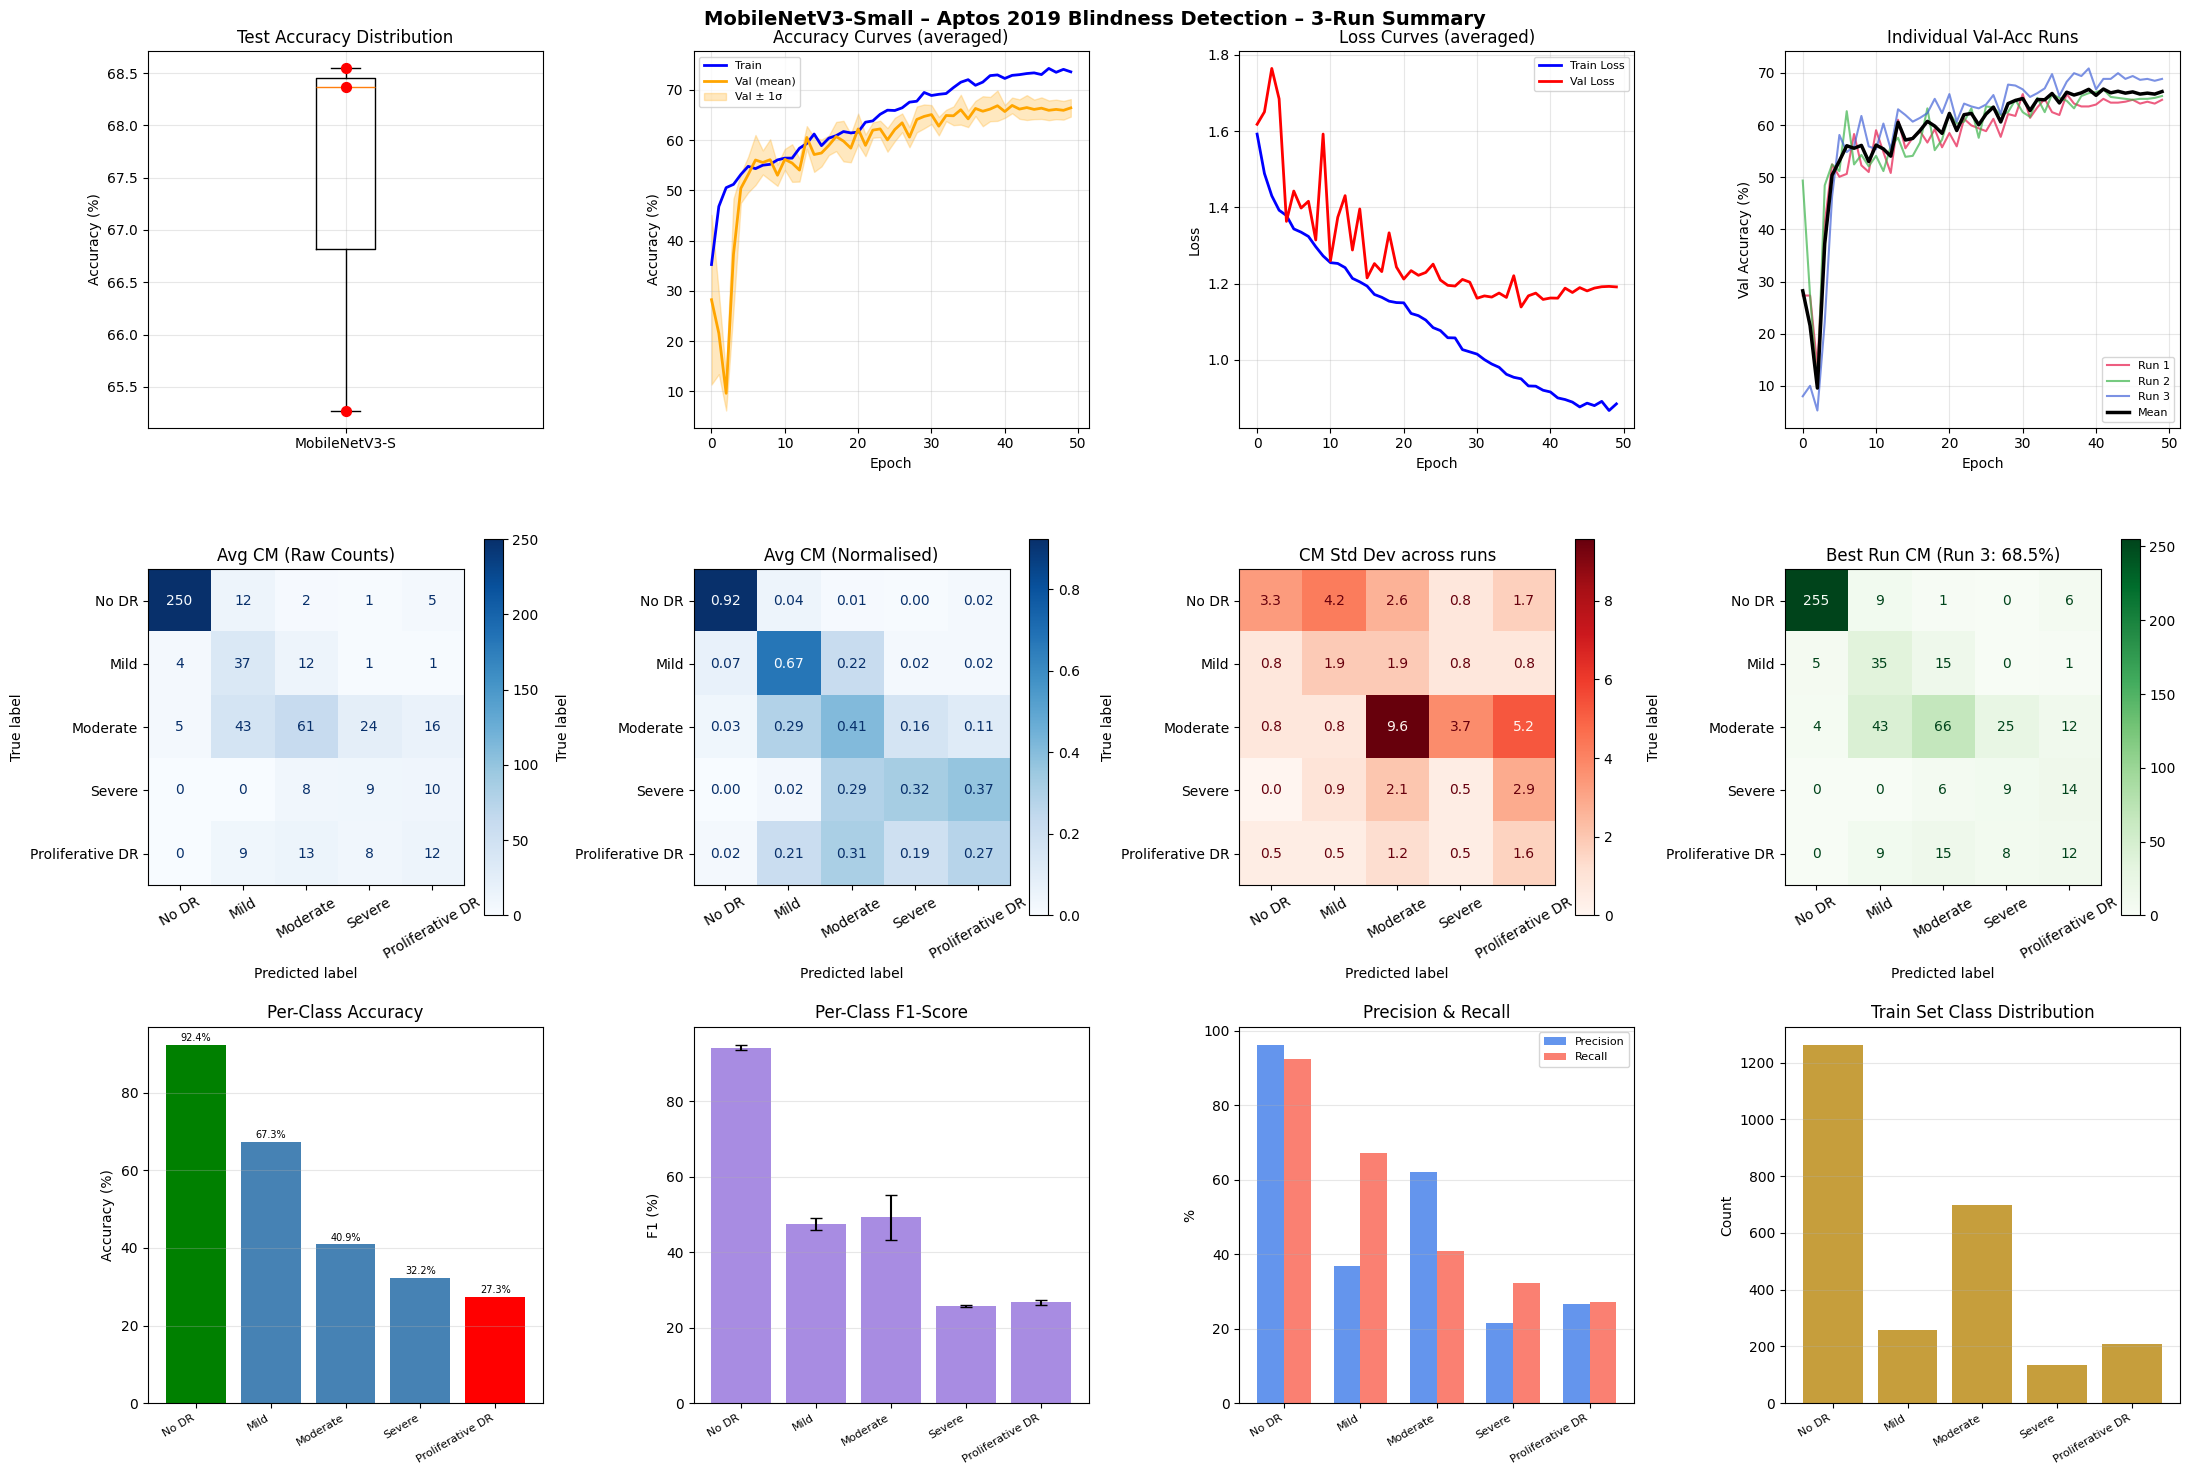


PERFORMANCE SUMMARY
Consistency (Test Acc Std)      : 1.50%
Average Per-Class Accuracy      : 52.00%
Class Performance Range         : 27.27% – 92.37%
Class Accuracy Std Dev          : 24.46%

Experiment completed.
Final averaged test accuracy: 67.39% ± 1.50%


In [12]:
if __name__ == "__main__":
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    results = run_experiment()
    print("\nExperiment completed.")
    print(f"Final averaged test accuracy: {results['mean_test_acc']:.2f}% ± {results['std_test_acc']:.2f}%")